In [57]:
import pandas as pd
import pandas as pd
import numpy 
import regex as re
import random
import sklearn
from scipy.stats import shapiro
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, LogisticRegression
from sklearn import metrics
from statsmodels.graphics.gofplots import qqplot

In [58]:
pheno = pd.read_table("pheno.txt")
data = pd.read_table("normalized_data.txt")

metadata = data.iloc[:, :4]
data = data.transpose()

data.columns = data.iloc[0]
data.drop(data.index[0:4], inplace=True)

data = data.apply(pd.to_numeric)

target = data.index.tolist()

#replace controls with 0 and patient with 1

target = [0 if re.search('[C]', x) else 1 for x in target ]

data["target"] = target



## Feature Selection


In [59]:
X = data.drop(["target"],axis=1)
y = data['target'].values
print(y)

data_rel = SelectKBest(f_classif, k=10).fit_transform(X, y)

data_rel = pd.DataFrame(data_rel)
data_rel["target"] = y

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


## Initial Model 
Let's fit our model on the real data first, so we have a baseline

In [60]:
X = data_rel.drop("target", axis = 1)
X = np.log(X)
y = data_rel["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[7, 1],
       [0, 6]])

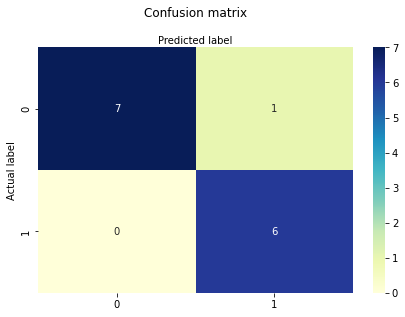

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=["Control","Case"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.Text(0.5,257.44,'Predicted label');

In [62]:
from sklearn.metrics import classification_report
target_names = ['without ME/CFS', 'with ME/CFS']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

without ME/CFS       1.00      0.88      0.93         8
   with ME/CFS       0.86      1.00      0.92         6

      accuracy                           0.93        14
     macro avg       0.93      0.94      0.93        14
  weighted avg       0.94      0.93      0.93        14



## Normality Checks

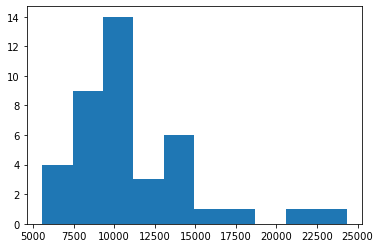

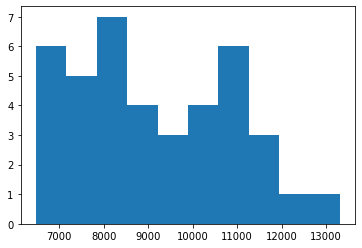

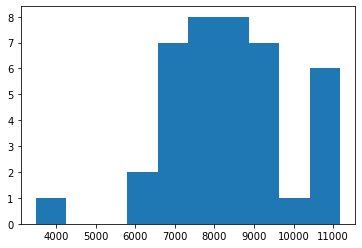

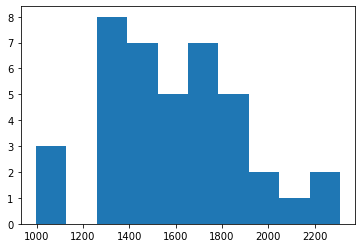

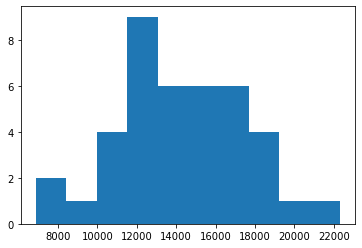

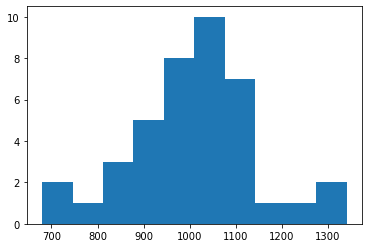

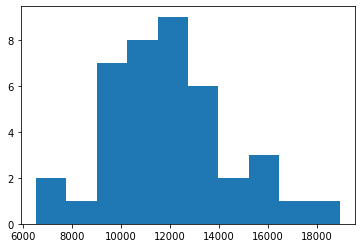

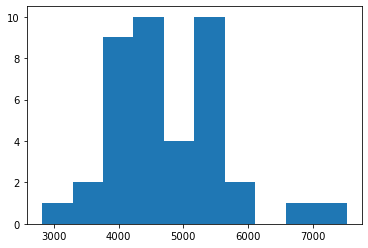

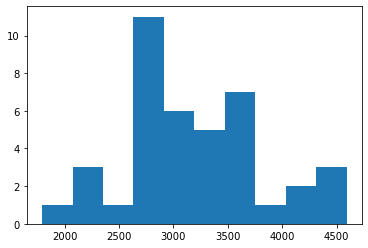

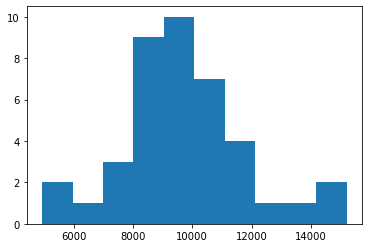

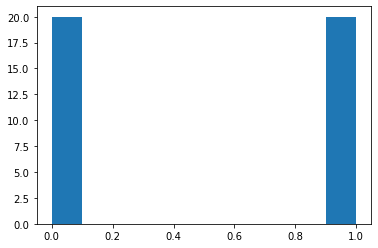

In [71]:
## histogram
for c in data_rel.columns:
    plt.hist(data_rel[c])
    plt.show()

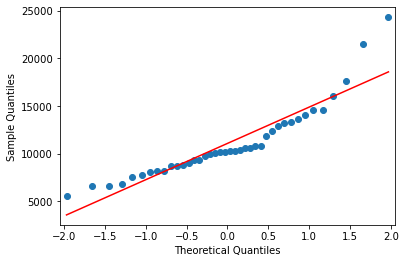

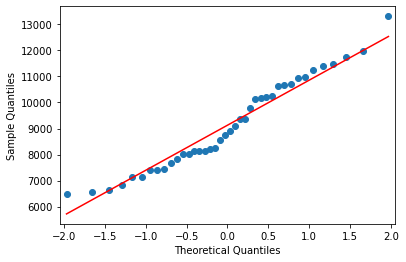

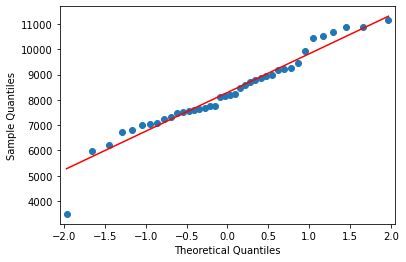

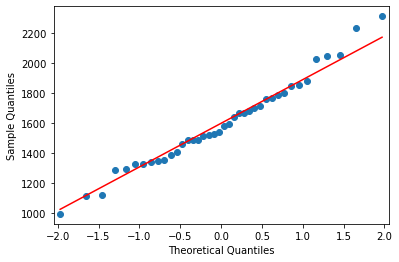

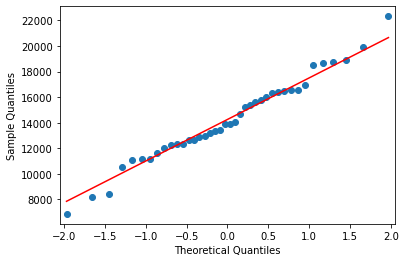

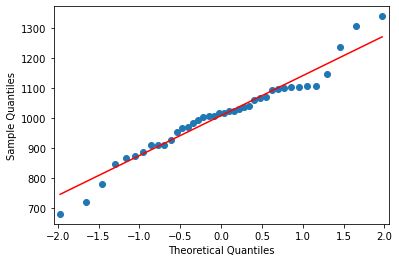

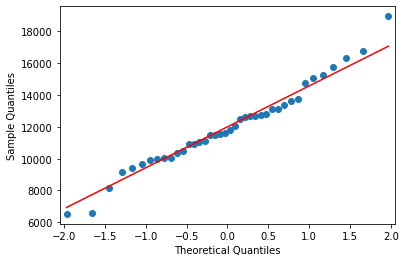

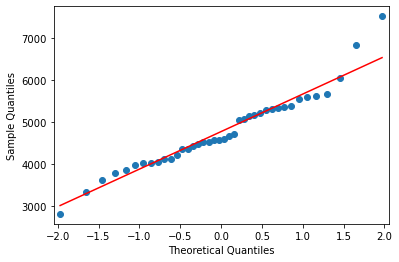

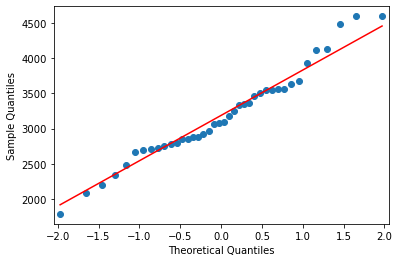

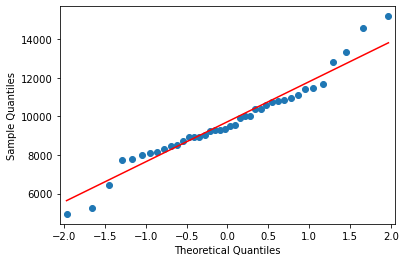

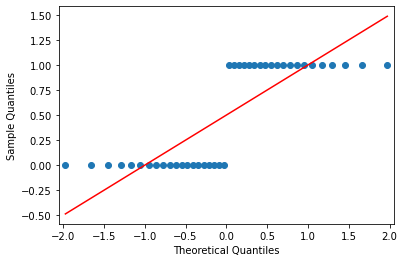

In [72]:
for c in data_rel.columns:
    qqplot(data_rel[c], line = "s")

## log transform

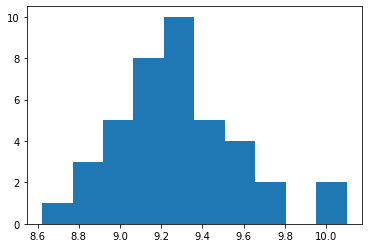

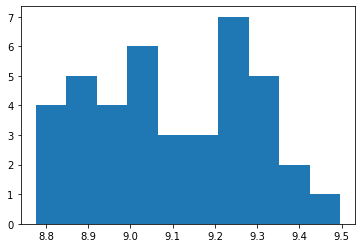

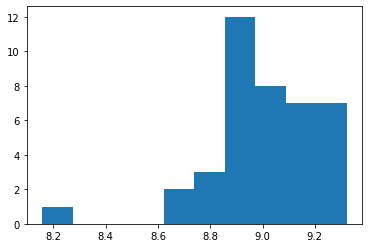

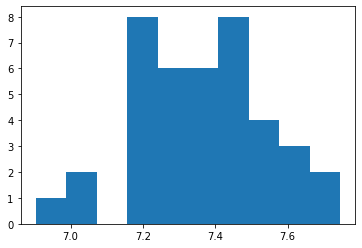

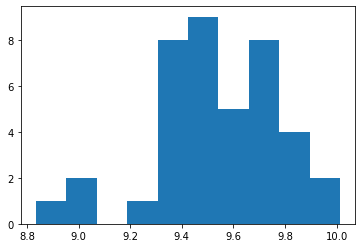

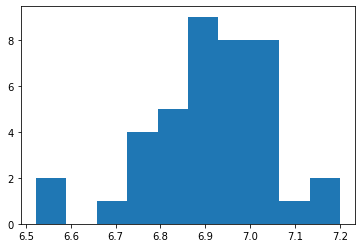

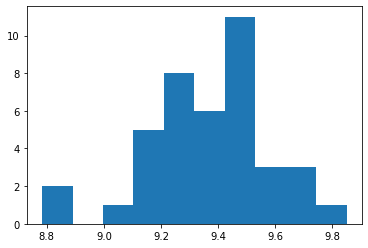

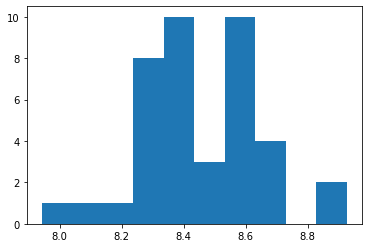

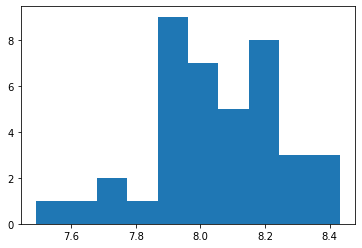

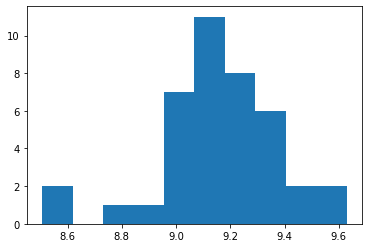

In [73]:
#X_train, X_test, y_train, y_test = train_test_split(np.log(rel_X), y, test_size=0.33, random_state=47)

for c in rel_X.columns:
    plt.hist(np.log(rel_X[c]))
    plt.show()

/Users/seanm/opt/anaconda3/envs/SummerEnv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/seanm/opt/anaconda3/envs/SummerEnv/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


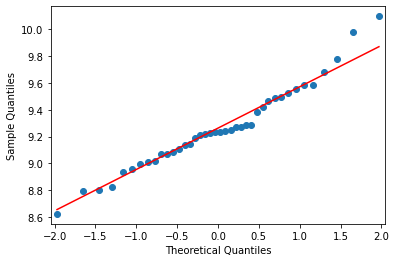

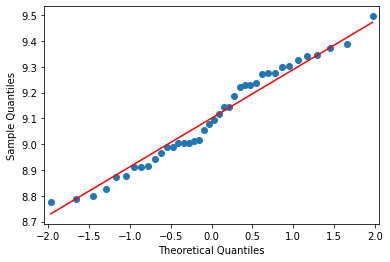

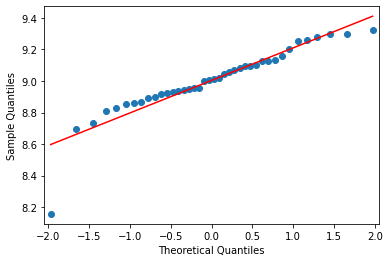

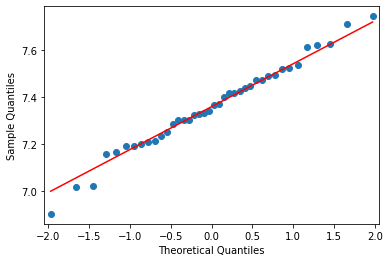

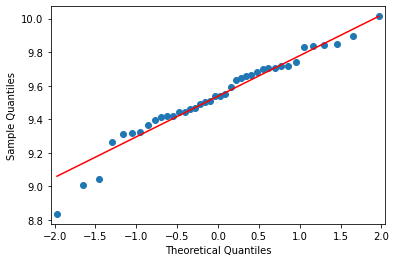

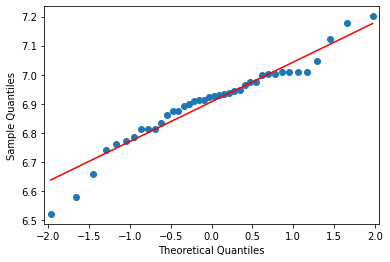

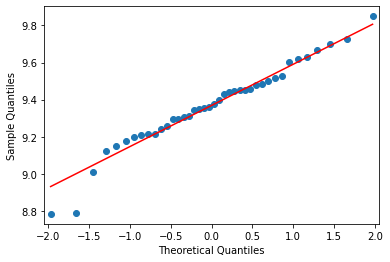

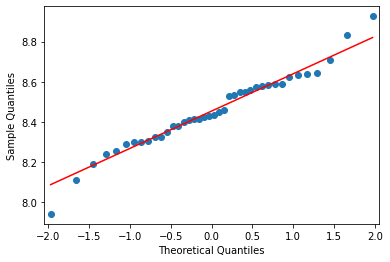

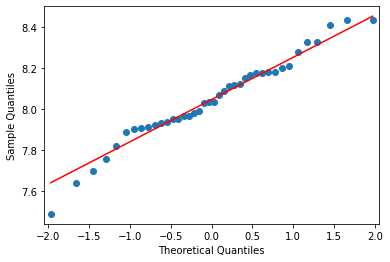

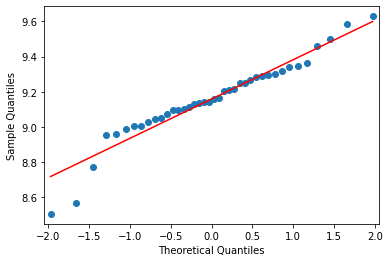

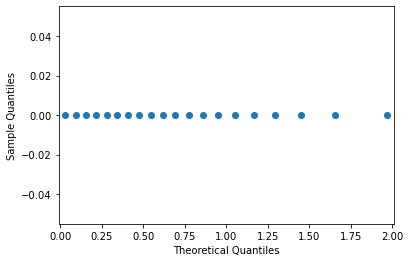

In [74]:
for c in data_rel.columns:
    qqplot(np.log(data_rel[c]), line = "s")

In [75]:
count = 1
for c in data_rel.columns:
    stat, p = shapiro(np.log(data_rel[c]))
    # interpret
    alpha = 0.05
    if p > alpha:
        print(f'Column {count} looks Gaussian (fail to reject H0)')
    else:
        print(f'Column {count} does not look Gaussian (reject H0)')
        print('Statistics=%.3f, p=%.3f' % (stat, p))
    count +=1

Column 1 looks Gaussian (fail to reject H0)
Column 2 looks Gaussian (fail to reject H0)
Column 3 does not look Gaussian (reject H0)
Statistics=0.883, p=0.001
Column 4 looks Gaussian (fail to reject H0)
Column 5 looks Gaussian (fail to reject H0)
Column 6 looks Gaussian (fail to reject H0)
Column 7 looks Gaussian (fail to reject H0)
Column 8 looks Gaussian (fail to reject H0)
Column 9 looks Gaussian (fail to reject H0)
Column 10 looks Gaussian (fail to reject H0)
Column 11 looks Gaussian (fail to reject H0)


/Users/seanm/opt/anaconda3/envs/SummerEnv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [66]:
def simulate_protein_data(df, obs):
    means = df.mean(axis=0).tolist()
    sds = df.std(axis=0).tolist()

    if len(means) != len(sds): ## sanity check
        return "List Imbalance"
    
    simulated_data = []
    for _ in range(obs):
        col = []
        for i in range(len(means)):
            col.append(random.gauss(means[i],sds[i]))
        simulated_data.append(col)
        

    simulated_dataframe = pd.DataFrame(simulated_data)
    return simulated_dataframe 


cases = data_rel[data_rel.target == 1]
controls = data_rel[data_rel.target == 0]

cases_s = simulate_protein_data(np.log(cases.drop("target", axis = 1)), 1000)
cases_s["target"] = 1
controls_s = simulate_protein_data(np.log(controls.drop("target", axis = 1)), 1000)
controls_s["target"] = 0

simul = pd.concat([cases_s, controls_s], ignore_index=True)


In [76]:
simul.to_csv("log_protein_simulated.csv")


## Testing on new



In [68]:
X = simul.drop("target", axis=1)
y = simul["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

/Users/seanm/opt/anaconda3/envs/SummerEnv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[311,   7],
       [  7, 335]])

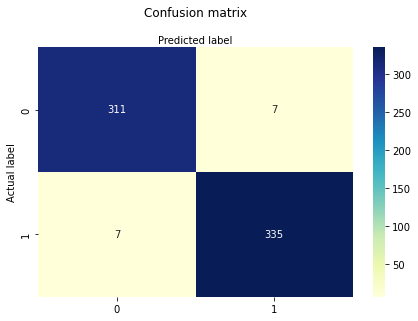

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=["Control","Case"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.Text(0.5,257.44,'Predicted label');

In [70]:
from sklearn.metrics import classification_report
target_names = ['without ME/CFS', 'with ME/CFS']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

without ME/CFS       0.98      0.98      0.98       318
   with ME/CFS       0.98      0.98      0.98       342

      accuracy                           0.98       660
     macro avg       0.98      0.98      0.98       660
  weighted avg       0.98      0.98      0.98       660

